In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [84]:
np.random.seed(42)
N = 200
D = 4
X = np.random.uniform(-5, 5, size=(N, D))

w = np.random.randn(D, 1)
f_true = lambda X: np.tanh(X.dot(w))     # shape (N,1)

# Noisy observations
noise_std = 0.1
y = f_true(X) + noise_std * np.random.randn(N, 1)

# Radial Basis Function Kernel
# Parameters are lengthscale and variance
# Larger the length scale, smoother the function
# Larger variance means larger vertical scale of the output
def rbf_kernel(X1, X2, lengthscale, variance):
    X1s = X1 / lengthscale # (N1, D)
    X2s = X2 / lengthscale # (N2, D)
    sq_dists = (
        np.sum(X1s**2, axis=1)[:,None] #(N1,1)
      + np.sum(X2s**2, axis=1)[None,:] #(1,N2) # with broadcasting it makes (N1,N2)
      - 2*X1s.dot(X2s.T) # (N1,N2)
    )
    return variance * np.exp(-0.5 * sq_dists)

In [85]:
# Compute the variational bound (eq. 9 in paper)
# sigma2 is the noise added to the final output y
# We DO NOT optimize pseudo-inputs X_m.
def variational_bound(params, X, y, m_idx):
    lengthscale, variance, sigma2 = params
    n = X.shape[0]
    # Inducing inputs
    if m_idx:
        Xm = X[m_idx]
        #Add the Identity matrix * 1e-8 to prevent the Kmm to be singular matrix
        Kmm = rbf_kernel(Xm, Xm, lengthscale, variance) + 1e-8 * np.eye(len(Xm))
        Kmn = rbf_kernel(Xm, X, lengthscale, variance)
        Z = np.linalg.solve(Kmm, Kmn) #Kmm^(-1)*Kmn
        Qnn = Kmn.T.dot(Z)
        # Trace term: Tr(Knn) - Tr(Qnn)
        trace_Knn = variance * n
        trace_Q = np.trace(Qnn)
        trace_term = trace_Knn - trace_Q
        # Build covariance C = Qnn + sigma2 I for likelihood
        C = Qnn + sigma2 * np.eye(n)
    else: #No inducing points
        trace_term = variance * n
        C = sigma2 * np.eye(n)
    # Log marginal likelihood part
    L = np.linalg.cholesky(C + 1e-6 * np.eye(n))
    #Since in the log likelihood of Gaussian, we have y'C^(-1)y term.
    #LL^t * alpha = y, alpha = C^(-1)*y
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y[:, 0]))
    #log det(C) = log (det(L)^2)
    log_det = 2 * np.sum(np.log(np.diag(L)))
    log_lik = -0.5 * (n * np.log(2 * np.pi) + log_det + y[:, 0].dot(alpha))
    # Variational lower bound
    F = log_lik - 0.5 / sigma2 * trace_term
    return F


In [86]:
# Greedy selection of inducing points + hyperparameter optimization
def objective(h):
    return -variational_bound(h, X, y, m_idx)

def greedy_variational_sparse_gp(X, y, M):
    n = X.shape[0]
    # Initialize hyperparameters: [lengthscale, variance, noise variance]
    params = [2.0, 0.1, 1.0]
    m_idx = []
    for i in range(M):
        best_j, best_F = None, -np.inf
        # E-step: select next inducing point by maximizing bound
        for j in range(n):
            if j in m_idx:
                continue
            F_val = variational_bound(params, X, y, m_idx + [j])
            if F_val > best_F:
                best_F, best_j = F_val, j
        m_idx.append(best_j)
        # M-step: optimize hyperparameters given current inducing set
        def objective(h):
            return -variational_bound(h, X, y, m_idx)
        res = minimize(objective, params, bounds=[(1e-5, None), (1e-5, None), (1e-5, None)])
        params = res.x.tolist()
        print(f"Iter {i+1}/{M}: added idx {best_j}, F={best_F:.3f}, params={params}")
    return m_idx, params

# Prediction using the learned variational parameters
def predict_variational_sparse_gp(X, y, X_test, m_idx, params):
    lengthscale, variance, sigma2 = params
    Xm = X[m_idx]
    Kmm = rbf_kernel(Xm, Xm, lengthscale, variance) + 1e-8 * np.eye(len(Xm))
    Kmn = rbf_kernel(Xm, X, lengthscale, variance)
    # Optimal variational distribution phi* parameters
    Sigma = np.linalg.inv(Kmm + (1/sigma2) * (Kmn.dot(Kmn.T))) #(m, m)
    mu_phi = (1/sigma2)*Kmm.dot(Sigma.dot(Kmn.dot(y[:, 0]))) #(m, 1)
    # Predictive mean
    K_test_m = rbf_kernel(X_test, Xm, lengthscale, variance) #(N_test, m)
    pred_mean = K_test_m.dot(np.linalg.solve(Kmm, mu_phi)) #(N_test, 1)
    # Predictive variance
    Kxx = rbf_kernel(X_test, X_test, lengthscale, variance) + 1e-6 * np.eye(len(X_test))
    Z = np.linalg.solve(Kmm, K_test_m.T) #(m, N_test)
    var1 = Kxx - K_test_m.dot(Z)
    var2 = K_test_m.dot(Sigma.dot(K_test_m.T))
    pred_var = var1 + var2
    return pred_mean, pred_var #(N_test,1) (N_test,N_test)

In [87]:
# Run the greedy variational sparse GP
M = 60  # number of inducing points
m_idx, learned_params = greedy_variational_sparse_gp(X, y, M)


Iter 1/60: added idx 194, F=-281.300, params=[3.643759106551008, 0.04099857846808683, 0.833329416528215]
Iter 2/60: added idx 85, F=-251.051, params=[14.901363854675756, 0.43485817083147543, 0.2771037477044246]
Iter 3/60: added idx 153, F=-165.915, params=[14.257076410234683, 0.46111601385829926, 0.24578547557550004]
Iter 4/60: added idx 195, F=-159.189, params=[22.00080696688834, 1.3456360903417355, 0.23565049950079295]
Iter 5/60: added idx 39, F=-150.766, params=[89.61144960006274, 90.36726753508533, 0.2141634922999328]
Iter 6/60: added idx 136, F=-144.842, params=[89.61142253501674, 90.36727957818283, 0.21366211181240718]
Iter 7/60: added idx 137, F=-144.694, params=[89.61139050448975, 90.36730594966009, 0.21306101418977388]
Iter 8/60: added idx 59, F=-144.600, params=[89.61135532033474, 90.36732736140456, 0.21285769229490678]
Iter 9/60: added idx 157, F=-144.534, params=[89.61130997513054, 90.36733849837863, 0.2126410745171139]
Iter 10/60: added idx 30, F=-144.500, params=[89.61129

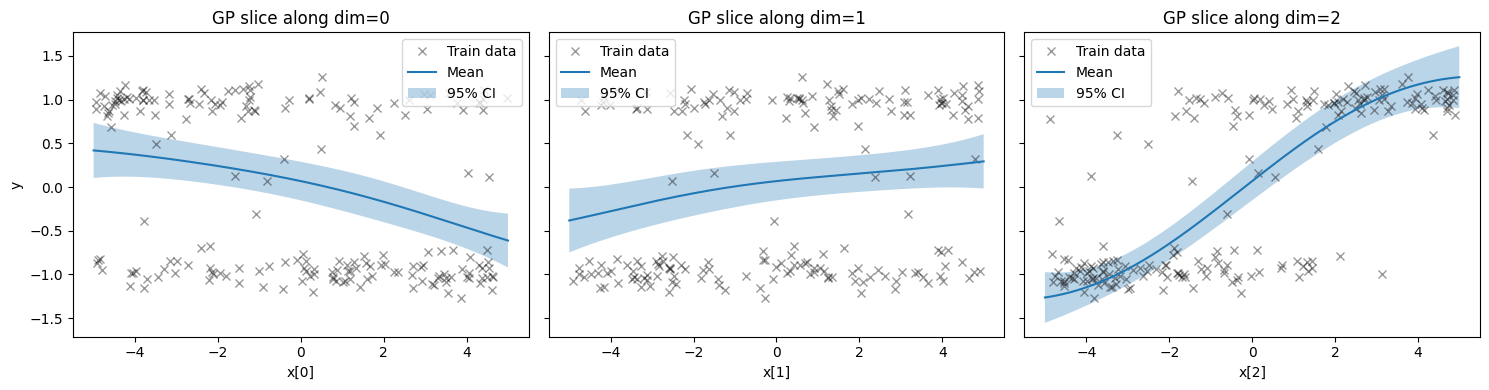

In [88]:
dims = [0, 1, 2]         # the coordinates you want to sweep over
n_plots = len(dims)
fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 4), sharey=True)

for ax, dim in zip(axes, dims):
    # build the test grid: vary only coordinate `dim`, others fixed at 0
    x_grid = np.linspace(-5, 5, 200)
    X_test = np.zeros((len(x_grid), D))
    X_test[:, dim] = x_grid

    # predict
    pred_mean, pred_cov = predict_variational_sparse_gp(X, y, X_test, m_idx, learned_params)
    pred_var_marginal = np.diag(pred_cov)
    std = np.sqrt(pred_var_marginal)

    # sort by the swept coordinate (not strictly necessary here, since x_grid is sorted)
    order = np.argsort(X_test[:, dim])
    x_plot    = X_test[order, dim]
    mean_plot = pred_mean[order]
    std_plot  = std[order]

    # plot
    ax.plot(X[:, dim], y[:, 0], 'kx', alpha=0.4, label='Train data')
    ax.plot(x_plot, mean_plot,     label='Mean')
    ax.fill_between(
        x_plot,
        mean_plot - 1.96*std_plot,
        mean_plot + 1.96*std_plot,
        alpha=0.3,
        label='95% CI'
    )
    ax.set_title(f'GP slice along dim={dim}')
    ax.set_xlabel(f'x[{dim}]')
    if dim == dims[0]:
        ax.set_ylabel('y')
    ax.legend()

plt.tight_layout()
plt.show()